<a href="https://colab.research.google.com/github/francobarrionuevoenv21/HPC_2025/blob/main/CA_Implt_GPUs_HPC2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 9.9 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1.2-cp312-cp312-linux_x86_64.whl size=659050 sha256=82bef1e3dfa1dcefb330b2bee5c19d435d546f67dc6063498232808676360ef5
  Stored in directory: /root/.cache/pip/wheels/d5/36/f3/ac5f09d768cad3fa15d5a3449bdfe65c3de58e69d036c73228
Successfully built pycuda


In [32]:
import pycuda.driver as drv
import pycuda.autoinit
from pycuda.compiler import SourceModule

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
x = 64
y = 64

## NDVI DATA

In [3]:
def calculate_p_den(water_thres, low_thres, high_thres, NDVI):
    water_value = 'water'
    low_value = 'nonflammable'
    mid_value = 'medium'
    high_value = 'dense'

    # Initialize ndvi_grouped with a default value or array
    #ndvi_grouped = np.empty_like(NDVI, dtype='<U10') # Using string dtype to hold the category names

    ndvi_grouped = np.where(NDVI >= high_thres, high_value, NDVI)
    ndvi_grouped = np.where((NDVI >= low_thres) & (NDVI < high_thres), mid_value, ndvi_grouped)
    ndvi_grouped = np.where((NDVI >= water_thres) & (NDVI < low_thres), low_value, ndvi_grouped)
    # The original code had this condition last, let's keep it for water
    ndvi_grouped = np.where(NDVI < water_thres, water_value, ndvi_grouped)


    return ndvi_grouped

def calculate_p_den_values(den_water, den_low, den_mid, den_high, ndvi_grouped):
    p_den = np.zeros_like(ndvi_grouped, dtype=float)  # numeric array

    p_den[ndvi_grouped == 'water'] = den_water
    p_den[ndvi_grouped == 'nonflammable'] = den_low
    p_den[ndvi_grouped == 'medium'] = den_mid
    p_den[ndvi_grouped == 'dense'] = den_high

    return p_den

In [6]:
NDVI_random = np.full((y, x), 0.8)   # x-component
#np.random.rand(x, y)

In [7]:
ndvi= NDVI_random
water_thres = 0.1
low_thres = 0.5
high_thres = 0.7

den_water = -1 # Using negative values for water to ensure it can't be enflamed
den_low = -1 # These are nonflammable areas
den_mid = 0 # These are the general areas
den_high = 0.2 # Dense areas have increased change of spreading

# Let's group the NDVI using the first function
ndvi_grouped = calculate_p_den(water_thres, low_thres, high_thres, ndvi)

# p_den is the one that will actually be used for calculation. Not that water and nonflammable are both -1, i.e., nonflammable.
# Otherwise, the more vegetation the higher the burn probability
p_den = calculate_p_den_values(den_water, den_low, den_mid, den_high, ndvi_grouped)


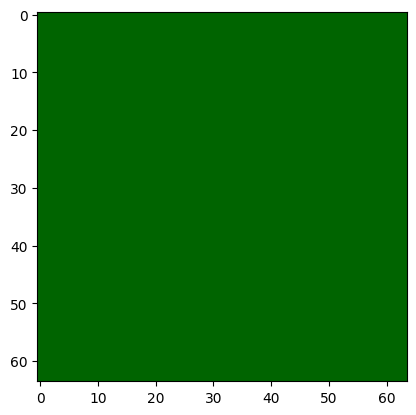

In [17]:
cmap_123 = ListedColormap(['darkgreen']) # ['blue', 'goldenrod', 'limegreen', 'darkgreen']
plt.imshow(p_den, cmap=cmap_123)
plt.show()

## INITIALIZATION

In [25]:
state = np.zeros((x, y), dtype=int)

FP_lon_index = int(x/2)
FP_lat_index = int(y/2)

state[FP_lon_index, FP_lat_index] = 1

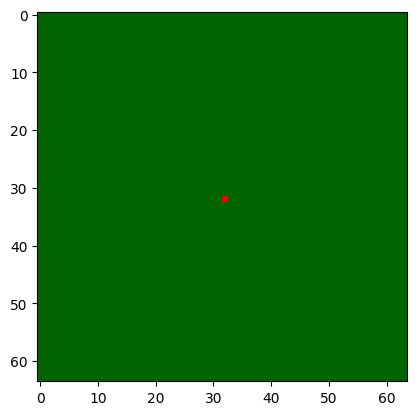

In [26]:
cmap_123 = ListedColormap(['darkgreen', 'red']) # ['blue', 'goldenrod', 'limegreen', 'darkgreen']
plt.imshow(state, cmap=cmap_123)
plt.show()

In [45]:
random_p = np.random.rand(x, y)

In [ ]:
random

In [27]:
p_h = 0.6
p_burn = p_h*(1+p_den)

In [28]:
p_burn

array([[0.72, 0.72, 0.72, ..., 0.72, 0.72, 0.72],
       [0.72, 0.72, 0.72, ..., 0.72, 0.72, 0.72],
       [0.72, 0.72, 0.72, ..., 0.72, 0.72, 0.72],
       ...,
       [0.72, 0.72, 0.72, ..., 0.72, 0.72, 0.72],
       [0.72, 0.72, 0.72, ..., 0.72, 0.72, 0.72],
       [0.72, 0.72, 0.72, ..., 0.72, 0.72, 0.72]])

## GPU IMPLEMENTATION

In [40]:
# 1. Definir kenel
mod = SourceModule ("""
    __global__ void compute_AC(int *state_in, int *state_out, float *ndvi, float *randm, int rows, int cols) {
        int row = (blockDim.x * blockIdx.x) + threadIdx.x;
        int col = (blockDim.y * blockIdx.y) + threadIdx.y;

        if ((row < rows) && (col < cols)) {
            int i = (row * cols) + col;    /* Row major */

            // Neighbors index
            int up          = i - cols;        // (row-1, col)
            int down        = i + cols;        // (row+1, col)
            int left        = i - 1;           // (row, col-1)
            int right       = i + 1;           // (row, col+1)
            int up_left     = i - cols - 1;    // (row-1, col-1)
            int up_right    = i - cols + 1;    // (row-1, col+1)
            int down_left   = i + cols - 1;    // (row+1, col-1)
            int down_right  = i + cols + 1;    // (row+1, col+1)

            // Neighbors check. Boundaries check not implement. ¡BE CAREFUL WITH ITERATIONS!

            // PREDICATED APPROACH
            int new_state = 0;  // default: not burning

            // If burnt or burning, it becomes burnt
            new_state = (state_in[i] >= 1) ? 2 : 0;

            // If any neighbor is burning
            int neighbor_burning = 0;
            if (row > 0) { // Check upper neighbors
              if (state_in[up] == 1) neighbor_burning = 1;
              if (col > 0 && state_in[up_left] == 1) neighbor_burning = 1;
              if (col < cols - 1 && state_in[up_right] == 1) neighbor_burning = 1;
            }
            if (row < rows - 1) { // Check lower neighbors
              if (state_in[down] == 1) neighbor_burning = 1;
              if (col > 0 && state_in[down_left] == 1) neighbor_burning = 1;
              if (col < cols - 1 && state_in[down_right] == 1) neighbor_burning = 1;
            }
            if (col > 0 && state_in[left] == 1) neighbor_burning = 1; // Check left neighbor
            if (col < cols - 1 && state_in[right] == 1) neighbor_burning = 1; // Check right neighbor


            // Apply spreading probability only if cell is not already burning/burnt
            if (new_state == 0 && neighbor_burning && randm[i] < ndvi[i]) {
              new_state = 1;
            }

            state_out[i] = new_state;
        }
    }
    """)

In [37]:
import math

In [53]:
H = x
W = y
T = 1000

# 1. Create host matrices
state = state.copy()
ndvi  = p_burn.copy()
randm = random_p.copy()

# 2. Allocate GPU memory
state_gpu_1 = drv.mem_alloc(state.nbytes)
state_gpu_2 = drv.mem_alloc(state.nbytes)
ndvi_gpu  = drv.mem_alloc(ndvi.nbytes)
randm_gpu = drv.mem_alloc(randm.nbytes)

# 3. Copy host → device (initial state to one buffer)
drv.memcpy_htod(state_gpu_1, state)
drv.memcpy_htod(ndvi_gpu, ndvi)
drv.memcpy_htod(randm_gpu, randm)

# 4. Invoke kernel (assuming you already compiled your CUDA source into 'mod')
comp_AC = mod.get_function("compute_AC")

dim = 32
grid_x = math.ceil(H / dim)
grid_y = math.ceil(W / dim)
block_dim = (dim, dim, 1)
grid_dim = (grid_x, grid_y)

# Call kernel with 6 parameters (state_in, state_out, ...)
# Double-buffering: Use two buffers and swap them
state_in = state_gpu_1
state_out = state_gpu_2

for t in range(T):
    comp_AC(state_in, state_out, ndvi_gpu, randm_gpu, np.intc(H), np.intc(W),
            block=block_dim, grid=grid_dim)

    # swap buffers for the next iteration
    state_in, state_out = state_out, state_in

# After the loop, copy the final state back to the host
final_state = np.empty_like(state)
drv.memcpy_dtoh(final_state, state_in)

In [56]:
state

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [55]:
final_state

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

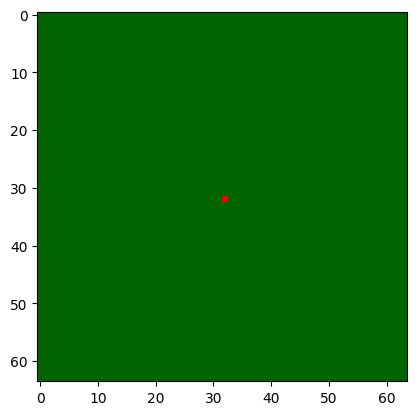

In [54]:
cmap_123 = ListedColormap(['darkgreen', 'red']) # ['blue', 'goldenrod', 'limegreen', 'darkgreen']
plt.imshow(final_state, cmap=cmap_123)
plt.show()

## WIND DATA

In [ ]:
U = np.full((y, x), 1.0)   # x-component
V = np.full((y, x), 1.0)   # y-component

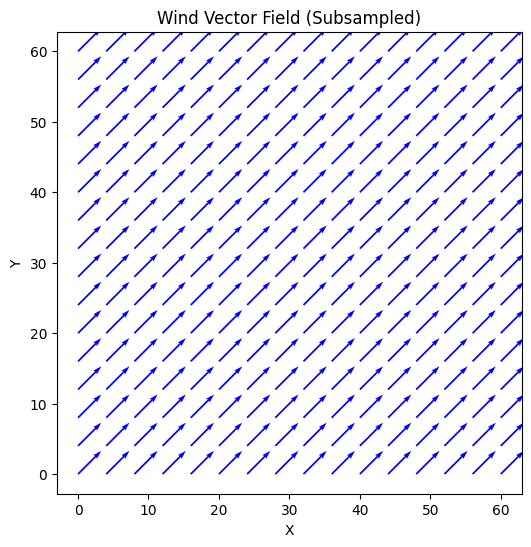

In [ ]:
X, Y = np.meshgrid(np.arange(x), np.arange(x))

# PLOT WIND DATA SUBSAMPLE
plt.figure(figsize=(6,6))
plt.quiver(
    X[::step, ::step],
    Y[::step, ::step],
    U[::step, ::step],
    V[::step, ::step],
    scale=20,
    color="blue"
)

'''plt.quiver(
    X,
    Y,
    U,
    V,
    scale=20,
    color="blue"
)'''
plt.title("Wind Vector Field (Subsampled)")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(30, 90)
plt.ylim(0, 90)
plt.axis("equal")
plt.show()

In [ ]:
n_t = 3 # timesteps

# fire_state = lon x lat
fire_state = np.zeros((n_t, x, y), dtype=int) #fire_state = np.zeros((n_t, len(x), len(y)), dtype=int)

In [ ]:
#p_burn = p_h * (1+p_den) # probability of burning
p_h = 0.6
p_burn = p_h*(1+p_den)

In [ ]:
p_burn

array([[0.72, 0.72, 0.  , ..., 0.  , 0.72, 0.6 ],
       [0.  , 0.6 , 0.  , ..., 0.72, 0.72, 0.  ],
       [0.72, 0.72, 0.72, ..., 0.  , 0.72, 0.  ],
       ...,
       [0.72, 0.  , 0.72, ..., 0.72, 0.  , 0.  ],
       [0.  , 0.72, 0.72, ..., 0.72, 0.6 , 0.72],
       [0.72, 0.  , 0.  , ..., 0.72, 0.  , 0.6 ]])

In [ ]:
#fire_state

In [ ]:
U[34][45], V[34][45]

(np.float64(1.0), np.float64(1.0))

In [ ]:
a = np.array([U[34][45], V[34][45]])
b = np.array([-1, 0])

def same_direction(A, B):
  dot = np.dot(A, B)
  norm = np.linalg.norm(A) * np.linalg.norm(B)
  cos_theta = dot / norm
  return cos_theta

same_direction(a, b)

np.float64(-0.7071067811865475)

In [ ]:
for i_t in range(1,n_t):
    for i in range(len(x)):
        for j in range(len(y)):
            # If cell is burnt it remains burnt
            if fire_state[i_t-1, i, j] == 2:
                fire_state[i_t, i, j] = 2
            # If cell was burning it turns into a burnt cell
            elif fire_state[i_t-1, i, j] == 1:
                fire_state[i_t, i, j] = 2
            # If cell is not burning and adjacent cell is burning, calculate if it turns to burning cell
            elif (i+1 < len(x) and fire_state[i_t-1, i+1, j] == 1) or \ # right pixel
               (i-1 >= 0 and fire_state[i_t-1, i-1, j] == 1) or \ # left pixel
               (j+1 < len(y) and fire_state[i_t-1, i, j+1] == 1) or \ # upper pixel
               (j-1 >= 0 and fire_state[i_t-1, i, j-1] == 1) or \ # lower pixel
               (i+1 < len(x) and j+1 < len(y) and fire_state[i_t-1, i+1, j+1] == 1) or \ # upper-right pixel
               (i-1 >= 0 and j-1 >= 0 and fire_state[i_t-1, i-1, j-1] == 1) or \ # lower-left pixel
               (i+1 < len(x) and j-1 >= 0 and fire_state[i_t-1, i+1, j-1] == 1) or \ # lower-right pixel
               (i-1 >= 0 and j+1 < len(y) and fire_state[i_t-1, i-1, j+1] == 1): # upper-left pixel
                if np.random.rand() < p_burn[i,j]:
                    fire_state[i_t, i, j] = 1
                else:
                    fire_state[i_t, i, j] = 0
            # All cells that are not burning and not adjacent to a burning cell remain unburnt
            else:
                fire_state[i_t, i, j] = fire_state[i_t-1, i, j]

# USELESS

In [ ]:
#  2D / 1 Block
#   doblar matriz
#   Implementación con SourceModule de duplicar elementos de una matriz.


!pip install pycuda

import pycuda.driver as drv
import pycuda.autoinit
from   pycuda.compiler import SourceModule
import numpy as np
import time


if __name__ == '__main__':

    # Parametros de configuracion:
    drv.init()
    dev = drv.Device(0) # Device 0
    max_thr_per_blk = dev.MAX_THREADS_PER_BLOCK
    print("MAX_THREADS_PER_BLOCK: ", max_thr_per_blk)

    # 1. Definir kenel
    mod = SourceModule ("""
    __global__ void doblar_matriz(float *a) {
        int row = (blockDim.x * blockIdx.x) + threadIdx.x;
        int col = (blockDim.y * blockIdx.y) + threadIdx.y;

        if ((row < 5) && (col < 5)) {
            int i = (row * 5) + col;   /* Row major */
            a[i] = a[i] * 2;
        }
    }
    """)

    # 2. Reserva memoria en GPU:
    H = 64
    W = 64
    a = np.arange(H * W, dtype=np.float32).reshape(H, W)
    print("Matriz:", a, a.nbytes)
    a_gpu = drv.mem_alloc(a.nbytes) # mem_alloc(size) asks the GPU to reserve size bytes in global memory

    # 3. Transferir datos host->GPU
    drv.memcpy_htod(a_gpu, a)

    # 4. Invoca kernel
    comp_AC = mod.get_function("compute_AC")
    comp_AC(a_gpu, block = (H, W, 1),
                  grid  = (1, 1, 1))

    # 5. Transferir datos GPU->host
    a_doubled = np.arange(H * W, dtype=np.float32)
    drv.memcpy_dtoh(a_doubled, a_gpu)

    print("Matriz doble:", a_doubled.reshape(H, W))

In [ ]:
# 1. Definir kenel
    mod = SourceModule ("""
    __global__ void compute_AC(int *state, float *ndvi, float *randm, int rows, int cols) {
        int row = (blockDim.x * blockIdx.x) + threadIdx.x;
        int col = (blockDim.y * blockIdx.y) + threadIdx.y;

        if ((row < rows) && (col < cols)) {
            int i = (row * cols) + col;    /* Row major */

            // Neighbors index
            int up          = i - cols;        // (row-1, col)
            int down        = i + cols;        // (row+1, col)
            int left        = i - 1;           // (row, col-1)
            int right       = i + 1;           // (row, col+1)
            int up_left     = i - cols - 1;    // (row-1, col-1)
            int up_right    = i - cols + 1;    // (row-1, col+1)
            int down_left   = i + cols - 1;    // (row+1, col-1)
            int down_right  = i + cols + 1;    // (row+1, col+1)

            // Neighbors check. Boundaries check not implement. ¡BE CAREFUL WITH ITERATIONS!
            //a[i] = a[i] * 2;

            if (state[i] == 2){ // If cell is burnt it remains burnt
                state[i] = 2;
            } else if (state[i] == 1){ // If cell was burning it turns into a burnt cell
                state[i] = 2;
            } if (state[up] == 1 || state[down] == 1 || state[left] == 1 || state[right] == 1 || state[up_left] == 1 || state[up_right] == 1 || state[down_left] == 1 || state[down_right] == 1) {
                if (randm[i] < ndvi[i]) {
                    state[i] = 1;
                } else {
                    state[i] = 0;
                }
              else{
                state[i] = 0;
              }
            }
        }
    }
    """)

In [ ]:
## ALTERNATIVE

# 1. Definir kernel
    mod = SourceModule ("""
    __global__ void compute_AC(int *state, float *ndvi, float *randm, int rows, int cols) {
        int row = (blockDim.x * blockIdx.x) + threadIdx.x;
        int col = (blockDim.y * blockIdx.y) + threadIdx.y;

        if ((row < rows) && (col < cols)) {
            int i = (row * cols) + col;    /* Row major */

            // Neighbors index
            int up          = i - cols;        // (row-1, col)
            int down        = i + cols;        // (row+1, col)
            int left        = i - 1;           // (row, col-1)
            int right       = i + 1;           // (row, col+1)
            int up_left     = i - cols - 1;    // (row-1, col-1)
            int up_right    = i - cols + 1;    // (row-1, col+1)
            int down_left   = i + cols - 1;    // (row+1, col-1)
            int down_right  = i + cols + 1;    // (row+1, col+1)

            // Neighbors check. Boundaries check not implement. ¡BE CAREFUL WITH ITERATIONS


            // PREDICATED APPROACH
            int new_state = 0;  // default: not burning

            // If burnt or burning, it becomes burnt
            new_state = (state[i] >= 1) ? 2 : 0;

            // If any neighbor is burning
            int neighbor_burning = (state[up]==1) || (state[down]==1) || (state[left]==1) || (state[right]==1) ||
                                  (state[up_left]==1) || (state[up_right]==1) || (state[down_left]==1) || (state[down_right]==1);

            // Apply spreading probability only if cell is not already burning/burnt
            new_state = (new_state == 0 && neighbor_burning && randm[i] < ndvi[i]) ? 1 : new_state;

            state[i] = new_state;
        }
    }
    """)

In [ ]:
# 1. Definir kenel
    mod = SourceModule ("""
    __global__ void compute_AC(int *state, float *ndvi, float *randm, int rows, int cols) {
        int row = (blockDim.x * blockIdx.x) + threadIdx.x;
        int col = (blockDim.y * blockIdx.y) + threadIdx.y;

        if ((row < rows) && (col < cols)) {
            int i = (row * cols) + col;    /* Row major */

            // Neighbors index
            int up          = i - cols;        // (row-1, col)
            int down        = i + cols;        // (row+1, col)
            int left        = i - 1;           // (row, col-1)
            int right       = i + 1;           // (row, col+1)
            int up_left     = i - cols - 1;    // (row-1, col-1)
            int up_right    = i - cols + 1;    // (row-1, col+1)
            int down_left   = i + cols - 1;    // (row+1, col-1)
            int down_right  = i + cols + 1;    // (row+1, col+1)

            // Neighbors check. Boundaries check not implement. ¡BE CAREFUL WITH ITERATIONS

            // PREDICATED APPROACH
            int new_state = 0;  // default: not burning

            // If burnt or burning, it becomes burnt
            new_state = (state[i] >= 1) ? 2 : 0;

            // If any neighbor is burning
            int neighbor_burning = (state[up]==1) || (state[down]==1) || (state[left]==1) || (state[right]==1) ||
                                  (state[up_left]==1) || (state[up_right]==1) || (state[down_left]==1) || (state[down_right]==1);

            // Apply spreading probability only if cell is not already burning/burnt
            new_state = (new_state == 0 && neighbor_burning && randm[i] < ndvi[i]) ? 1 : new_state;

            state[i] = new_state;
        }
    }
    """)

H = 64
W = 64

# 1. Create host matrices
state = #
ndvi  = #
randm = #

# 2. Allocate GPU memory
state_gpu = drv.mem_alloc(state.nbytes)
ndvi_gpu  = drv.mem_alloc(ndvi.nbytes)
randm_gpu = drv.mem_alloc(randm.nbytes)

# 3. Copy host → device
drv.memcpy_htod(state_gpu, state)
drv.memcpy_htod(ndvi_gpu, ndvi)
drv.memcpy_htod(randm_gpu, randm)

# 4. Invoke kernel (assuming you already compiled your CUDA source into 'mod')
comp_AC = mod.get_function("compute_AC")

dim =32
grid_x = math.ceil(H / dim)
grid_y = math.ceil(W / dim)

# Call kernel with 5 parameters
state_old = state_gpu.copy()  # first copy
'''
Double-buffering: Some cells might ignite sooner than they should, because they
see neighbors that have already been updated in this iteration.
'''

for t in range(T):
    comp_AC(state_old, ndvi_gpu, randm_gpu, np.intc(H), np.intc(W),
            block=block_dim, grid=grid_dim)

    # swap buffers
    state_old, state_gpu = state_gpu, state_old

In [2]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 9.9 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1.2-cp312-cp312-linux_x86_64.whl size=659050 sha256=27faf1b4d2209fcaf786e2d7790280ee641bc6d06945c8d9f8bcee8d677fb694
  Stored in directory: /root/.cache/pip/wheels/d5/36/f3/ac5f09d768cad3fa15d5a3449bdfe65c3de58e69d036c73228
Successfully built pycuda


In [3]:
import pycuda.driver as drv
import pycuda.autoinit
from   pycuda.compiler import SourceModule